In [26]:
import matplotlib.pyplot as plt
import wordcloud
import logging
import collections
import re
import nltk
import pandas as pd
import numpy as np
from PIL import Image

#Tokenizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

logger = logging.getLogger('FraudEmails')

frequency = 100
numb_of_words = 400

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jseme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jseme\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [27]:
#Open and convert file to String
try:
    with open('../data/fraudulent_emails.txt','r') as file:
        text = file.read()
except Exception as e:
    logger.error('Process failed with error: '+repr(e))
finally:
    file.close()



In [28]:
#Delete everything between From r [.*?] Status: ?O
formatEmails = re.sub('From.*?Status: ?O','',text,flags=re.DOTALL)


In [29]:
#Convert to lower case
formatEmails = formatEmails.lower()

In [30]:
#Tokenize
formatEmailsList = nltk.word_tokenize(formatEmails)

In [31]:
#Correspond every entry to tag from https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
tags = nltk.pos_tag(formatEmailsList)

In [32]:
df = pd.DataFrame(tags)
df.columns = ['word','tag']
df.head()

,word,tag
0,from,IN
1,:,:
2,mr.,NN
3,james,NNS
4,ngola,RB


In [33]:
#Verb dataframe
dfverb = df[df['tag']=='VB']
dfverb = dfverb.word.value_counts().reset_index()
dfverb = dfverb[dfverb['word']>frequency]
dfverb.head()

,index,word
0,be,5387
1,i,1492
2,please,691
3,contact,669
4,assist,647


In [34]:
#Noun dataframe
dfnoun = df[df['tag']=='NN']
dfnoun = dfnoun.word.value_counts().reset_index()
dfnoun = dfnoun[dfnoun['word']>frequency]
dfnoun.head()

,index,word
0,i,7576
1,money,3967
2,bank,3455
3,br,3182
4,account,3136


In [35]:
#Adjective dataframe
dfadj = df[df['tag']=='JJ']
dfadj = dfadj.word.value_counts().reset_index()
dfadj = dfadj[dfadj['word']>frequency]
dfadj.head()

,index,word
0,i,2170
1,foreign,1582
2,next,1412
3,united,826
4,late,803


In [36]:
#Noun plural dataframe
dfnounpl = df[df['tag']=='NNS']
dfnounpl = dfnounpl.word.value_counts().reset_index()
dfnounpl = dfnounpl[dfnounpl['word']>frequency]
dfnounpl.head()

,index,word
0,dollars,1169
1,funds,1047
2,i,1023
3,states,590
4,years,558


In [37]:
#Keep JJ (adjectives), NN (singular nouns), NNS (plural nouns), VB (verb)
toKeep = ['JJ','NN','NNS','VB']

#Get only work if tag is associated with above list
forWordCloud = [tag[0] for tag in tags if tag[1] in toKeep]


In [38]:
#Create dictionary with count of each entry
scamDict = collections.Counter(forWordCloud)


In [39]:
#Remove math equations/nonsense/single letters using previously defined dataframes
toRemove = ['tel','i','br','%','nbsp','content-transfer-encoding','content-type','=20','font-size','s','r','href=','=','<','>','div','/div','sum','mr.','http','d','e','text/plain','text/html','transaction=2e','l','href','font','text','mr=2e','t','country=2e','you=2e','other','charset=','dear','have','get','do','be','come','know','make','want','take','let','like','go','use','release','stand','keep','hear','p','style=','apply','put','ask','fail','call','operate','introduce','see','reach','bring','visit','look','serve','allow','other','new','south','quoted-printable','charset=iso-8859-1']
for removal in toRemove:
    del scamDict[removal]

In [40]:
#Remove less than 100 instances
scamDict = {k: v for k, v in scamDict.items() if v > frequency}


In [41]:
#Open mask and create word cloud
nigeriaMask = np.array(Image.open('../data/NigeriaOutline.jpg'))
scamCloud = wordcloud.WordCloud(width=800,height=800,
                                max_words=numb_of_words,mask=nigeriaMask,
                                contour_width=1,contour_color='green').generate_from_frequencies(scamDict)


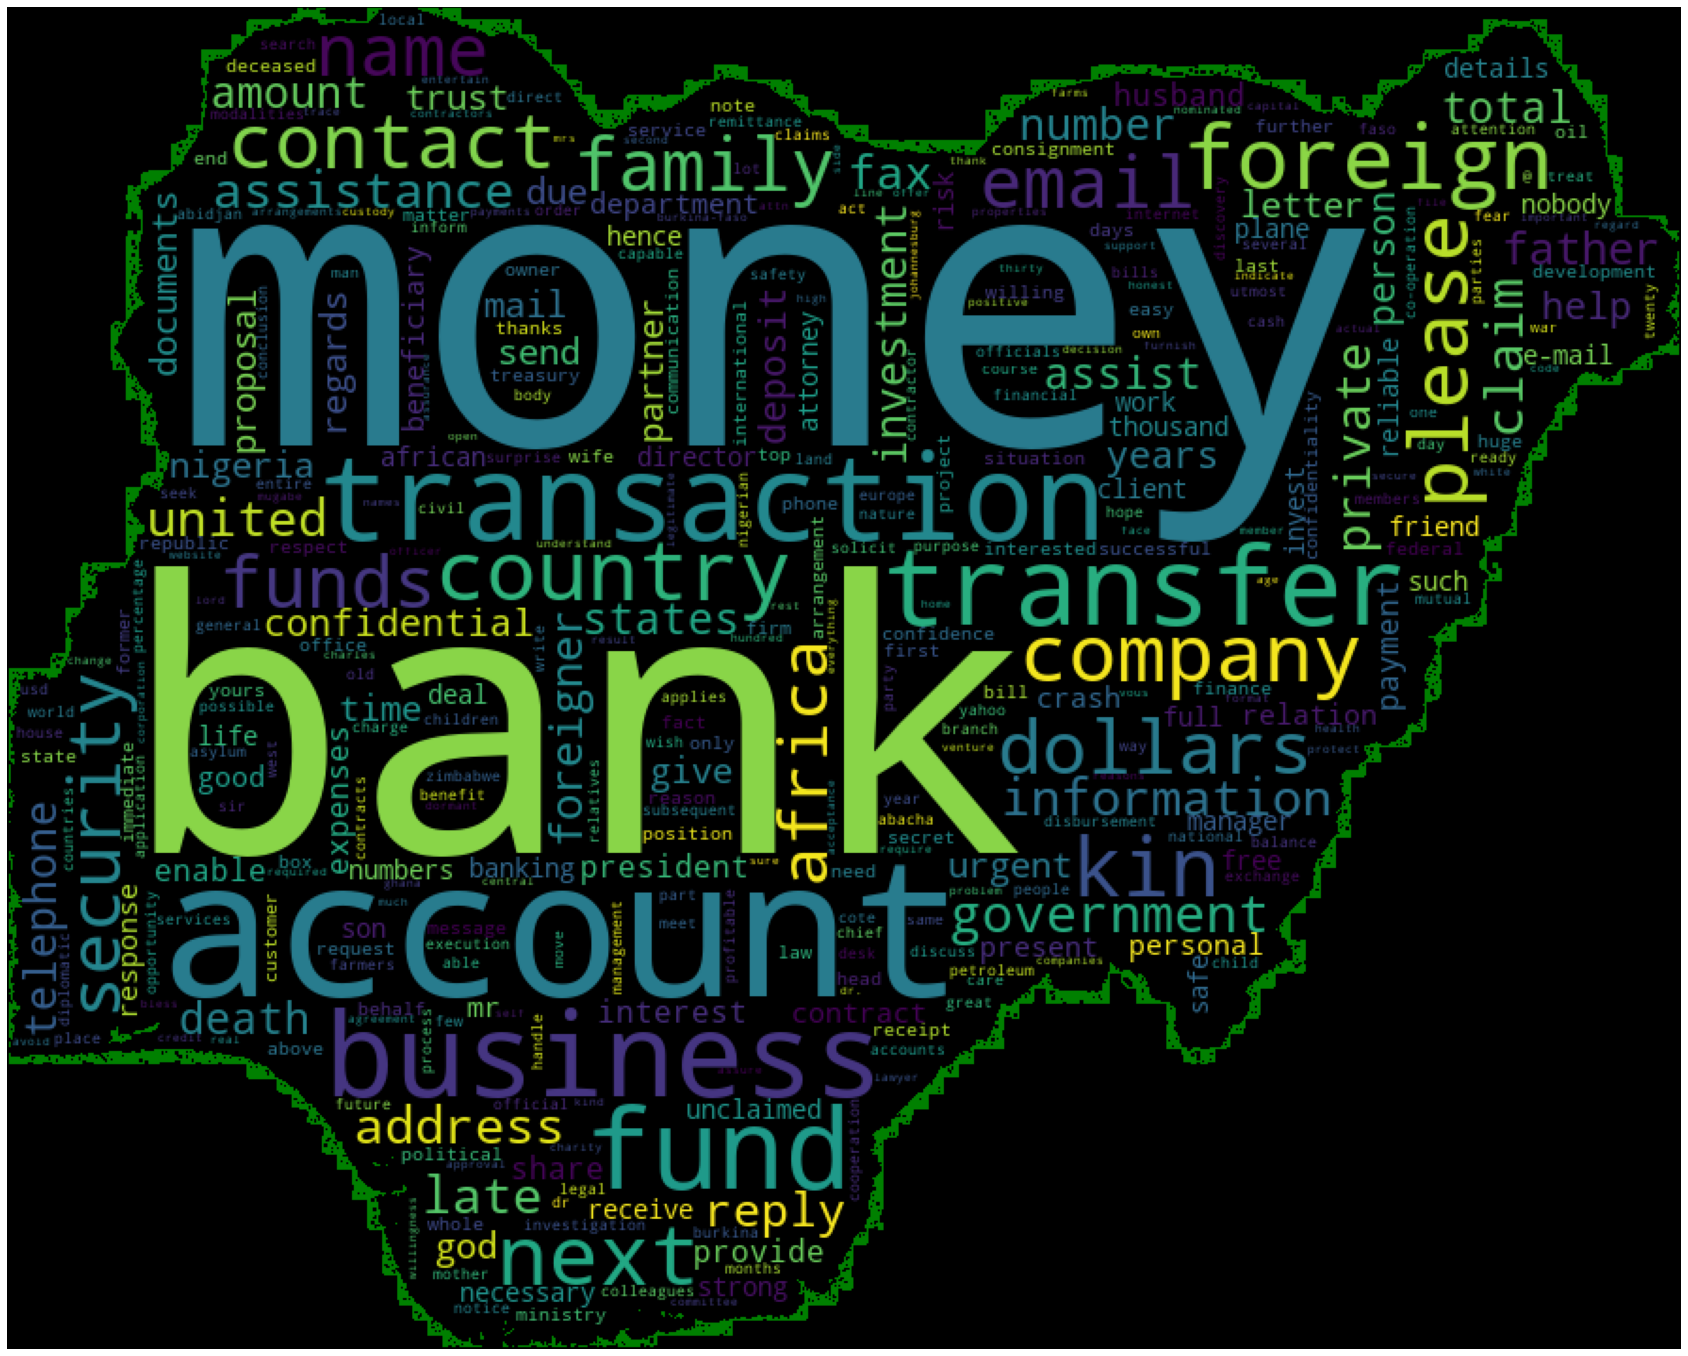

In [42]:
#Create image
plt.figure(figsize=(30,30))
plt.imshow(scamCloud)
plt.axis('off')
plt.savefig('../output/NigeriaScamWordCloud.png',bbox_inches='tight',pad_inches=0,dpi=133)

In [43]:
#Output unformatted frequency
outputrawdf = pd.concat([dfadj, dfnoun, dfnounpl, dfverb]).sort_values(by=['word'],ascending=False).reset_index(drop=True)
outputrawdf.to_csv('../output/WordFrequency_Unprocessed.csv',index=False,header=False)
outputrawdf.head()

,index,word
0,i,7576
1,be,5387
2,money,3967
3,bank,3455
4,br,3182


In [44]:
#Output formatted frequency
outputformatdf = pd.DataFrame.from_dict(scamDict, orient='index').sort_values(by=[0],ascending=False)
outputformatdf.to_csv('../output/WordFrequency_Processed.csv',header=False)
outputformatdf.head()

,0
money,3967
bank,3455
account,3153
transaction,1858
business,1815
